In [1]:
import os
os.getcwd()

'/home/serkan/Belgeler/bilsem23_24/proje/dog_emotions'

In [2]:
import os

classes = ['angry', 'happy', 'relaxed', 'sad']
source_directory = os.path.join(os.getcwd(), 'images')
files_dict = dict()
for c in classes:
    source_class_dir = os.path.join(source_directory, c)
    file_list = os.listdir(source_class_dir)
    files_dict[c] = file_list



In [3]:
base_directory = os.path.join(os.getcwd(), 'data')
if not os.path.exists(base_directory):
    os.mkdir(base_directory)
train_directory = os.path.join(base_directory, 'train')
validation_directory = os.path.join(base_directory, 'valid')
test_directory = os.path.join(base_directory, 'test')

if not os.path.exists(train_directory):
    os.mkdir(train_directory)
if not os.path.exists(validation_directory):
    os.mkdir(validation_directory)
if not os.path.exists(test_directory):
    os.mkdir(test_directory)

In [4]:
for c in classes:
    train_class_dir = os.path.join(train_directory, c)
    validation_class_dir = os.path.join(validation_directory, c)
    test_class_dir = os.path.join(test_directory, c)

    if not os.path.exists(train_class_dir):
        os.mkdir(train_class_dir)
    if not os.path.exists(validation_class_dir):
        os.mkdir(validation_class_dir)
    if not os.path.exists(test_class_dir):
        os.mkdir(test_class_dir)


In [5]:
import random

train_proportion = 0.80
valid_proportion = 0.10
test_proportion = 0.10

train_files_dict = {}
valid_files_dict = {}
test_files_dict = {}

for c in classes:
    file_list = files_dict[c]
    random.shuffle(file_list)
    file_count = len(file_list)
    train_count = int(file_count * train_proportion)
    valid_count = int(file_count * valid_proportion)
    test_count = int(file_count * test_proportion)

    train_files = file_list[:train_count]
    valid_files = file_list[train_count:train_count + valid_count]
    test_files = file_list[train_count + valid_count:]

    train_files_dict[c] = train_files
    valid_files_dict[c] = valid_files
    test_files_dict[c] = test_files

In [6]:
for c in classes:
    print(c)
    print("train:",len(train_files_dict[c]))
    print("valid",len(valid_files_dict[c]))
    print("test:",len(test_files_dict[c]))
    print("total:",len(files_dict[c]))

angry
train: 1804
valid 225
test: 227
total: 2256
happy
train: 3827
valid 478
test: 479
total: 4784
relaxed
train: 3479
valid 434
test: 436
total: 4349
sad
train: 3625
valid 453
test: 454
total: 4532


In [7]:
for c in classes:
    for f in train_files_dict[c]:
        source = os.path.join(source_directory, c, f)
        destination = os.path.join(train_directory, c, f)
        os.symlink(source, destination)
    for f in valid_files_dict[c]:
        source = os.path.join(source_directory, c, f)
        destination = os.path.join(validation_directory, c, f)
        os.symlink(source, destination)
    for f in test_files_dict[c]:
        source = os.path.join(source_directory, c, f)
        destination = os.path.join(test_directory, c, f)
        os.symlink(source, destination)


In [8]:
from keras.layers import MaxPooling2D,Conv2D,Flatten,Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import losses
from keras import metrics

2024-01-09 19:39:28.647232: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 19:39:28.648854: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-09 19:39:28.673768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 19:39:28.673796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 19:39:28.673813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [9]:
# veri çeşitlendirme/artırma(data augmentation)  dahil edilen imaja üretici
datagen_ag = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
# veri çeşitlendirme/artırma(data augmentation)  dahil edilmemiş imaja üretici
datagen = ImageDataGenerator(
    rescale=1./255,
)

In [10]:
# dizinden eğitim ve doğrulama dosyalarını çekerek eğitim veri kümesi ile doğrulama veri kümsesinin oluşturulması

train_generator=datagen_ag.flow_from_directory(
    directory=train_directory,
    target_size=(256,256),
    batch_size=64,
    class_mode="categorical"
)
validation_generator=datagen_ag.flow_from_directory(
    directory=validation_directory,
    target_size=(256,256),
    batch_size=64,
    class_mode="categorical"
)

Found 12735 images belonging to 4 classes.
Found 1590 images belonging to 4 classes.


In [11]:
for data_patch,label_patch in train_generator:
    print(data_patch.shape)
    print(label_patch.shape)
    break

(64, 256, 256, 3)
(64, 4)


(64, 256, 256, 3)


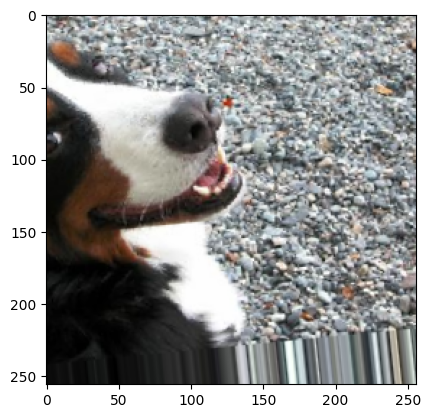

(64, 256, 256, 3)


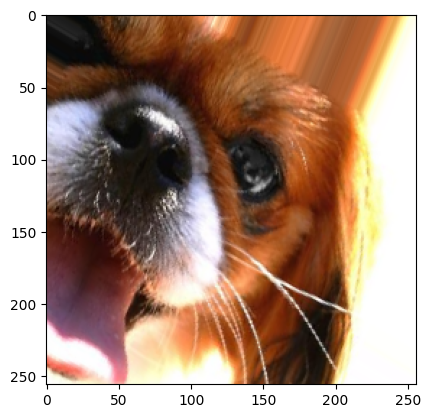

(64, 256, 256, 3)


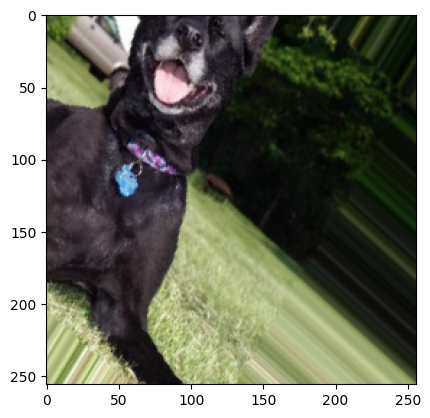

(64, 256, 256, 3)


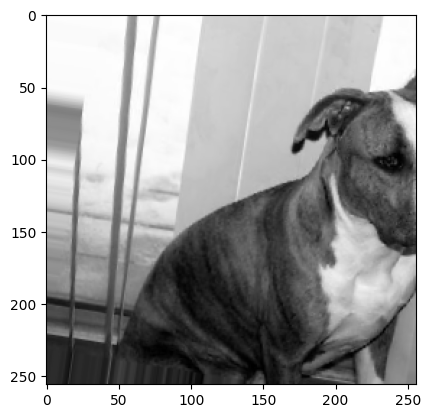

In [12]:
import matplotlib.pyplot as plt
for _ in range(4):
    image, label = train_generator.next()
    print(image.shape)
    plt.imshow(image[0])
    plt.show()

In [13]:
import numpy as np
from PIL import Image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import regularizers
import tensorflow as tf
import keras

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 256*256 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(4, activation='softmax')
])



model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

2024-01-09 19:39:32.781697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 19:39:32.781975: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [15]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
import pickle
import math
from keras.models import Sequential, Model, model_from_json

es=EarlyStopping(monitor="val_accuracy",mode="max",patience=5)
checkpoint = ModelCheckpoint('dog_emotions_cnn_{epoch:02d}-{val_accuracy:.2f}.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[checkpoint,es])

Epoch 1/50
  9/199 [>.............................] - ETA: 17:29 - loss: 1.3673 - accuracy: 0.2778 - auc: 0.5752 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 